<a href="https://colab.research.google.com/github/rachitj27/pneumonia-detection/blob/main/github_PneumoniaDetection_Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow.keras as keras
import keras.optimizers as optimizers
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet121


class pkg:
  #### DOWNLOADING AND LOADING DATA
  def get_metadata(metadata_path, which_splits = ['train', 'test']):
    '''returns metadata dataframe which contains columns of:
       * index: index of data into numpy data
       * class: class of image
       * split: which dataset split is this a part of?
    '''
    metadata = pd.read_csv(metadata_path)
    keep_idx = metadata['split'].isin(which_splits)
    return metadata[keep_idx]

  def get_data_split(split_name, flatten, all_data, metadata, image_shape):
    '''
    returns images (data), labels from folder of format [image_folder]/[split_name]/[class_name]/
    flattens if flatten option is True
    '''
    sub_df = metadata[metadata['split'].isin([split_name])]
    index  = sub_df['index'].values
    labels = sub_df['class'].values
    data = all_data[index,:]
    if flatten:
      data = data.reshape([-1, np.product(image_shape)])
    return data, labels

  def get_train_data(flatten, all_data, metadata, image_shape):
    return get_data_split('train', flatten, all_data, metadata, image_shape)

  def get_test_data(flatten, all_data, metadata, image_shape):
    return get_data_split('test', flatten, all_data, metadata, image_shape)

class helpers:
  #### PLOTTING
  def plot_one_image(data, labels = [], index = None, image_shape = [64,64,3]):
    '''
    if data is a single image, display that image

    if data is a 4d stack of images, display that image
    '''
    num_dims   = len(data.shape)
    num_labels = len(labels)

    # reshape data if necessary
    if num_dims == 1:
      data = data.reshape(target_shape)
    if num_dims == 2:
      data = data.reshape(np.vstack[-1, image_shape])
    num_dims   = len(data.shape)

    # check if single or multiple images
    if num_dims == 3:
      if num_labels > 1:
        print('Multiple labels does not make sense for single image.')
        return

      label = labels
      if num_labels == 0:
        label = ''
      image = data

    if num_dims == 4:
      image = data[index, :]
      label = labels[index]

    # plot image of interest
    print('Label: %s'%label)
    plt.imshow(image)
    plt.show()

  def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    # i'm sorry for this function's code. i am so sorry.
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 4)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

class models:
  def DenseClassifier(hidden_layer_sizes, nn_params):
    model = Sequential()
    model.add(Flatten(input_shape = nn_params['input_shape']))
    model.add(Dropout(0.5))

    for ilayer in hidden_layer_sizes:
      model.add(Dense(ilayer, activation = 'relu'))
      model.add(Dropout(0.5))

    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))
    model.compile(loss=nn_params['loss'],
                  optimizer= keras.optimizers.SGD(learning_rate=1e-4, momentum=0.95),
                  metrics=['accuracy'])
    return model

  def CNNClassifier(num_hidden_layers, nn_params):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=nn_params['input_shape'], padding = 'same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(num_hidden_layers-1):
        model.add(Conv2D(64, (3, 3), padding = 'same', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 64, activation = 'relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Dense(units = nn_params['output_neurons'], activation = nn_params['output_activation']))

    # initiate RMSprop optimizer
    opt = keras.optimizers.legacy.RMSprop(learning_rate=1e-5, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss=nn_params['loss'],
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

  def TransferClassifier(name, nn_params, trainable = True):
    expert_dict = {'VGG16': VGG16,
                   'VGG19': VGG19,
                   'ResNet50':ResNet50,
                   'DenseNet121':DenseNet121}

    expert_conv = expert_dict[name](weights = 'imagenet',
                                              include_top = False,
                                              input_shape = nn_params['input_shape'])
    for layer in expert_conv.layers:
      layer.trainable = trainable

    expert_model = Sequential()
    expert_model.add(expert_conv)
    expert_model.add(GlobalAveragePooling2D())

    expert_model.add(Dense(128, activation = 'relu'))
    expert_model.add(Dropout(0.5))

    expert_model.add(Dense(64, activation = 'relu'))
    expert_model.add(Dropout(0.5))

    expert_model.add(Dense(nn_params['output_neurons'], activation = nn_params['output_activation']))

    expert_model.compile(loss = nn_params['loss'],
                  optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
                  metrics=['accuracy'])

    return expert_model

### defining project variables
# file variables
metadata_url         = "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
image_data_url       = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy'
image_data_path      = './image_data.npy'
metadata_path        = './metadata.csv'
image_shape          = (64, 64, 3)

# neural net parameters
nn_params = {}
nn_params['input_shape']       = image_shape
nn_params['output_neurons']    = 1
nn_params['loss']              = 'binary_crossentropy'
nn_params['output_activation'] = 'sigmoid'

###
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/metadata.csv"
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20(Healthcare%20A)%20Pneumonia/image_data.npy"

### pre-loading all data of interest
_all_data = np.load('image_data.npy')
_metadata = pkg.get_metadata(metadata_path, ['train','test','field'])

### preparing definitions
# downloading and loading data
get_data_split = pkg.get_data_split
get_metadata    = lambda :                 pkg.get_metadata(metadata_path, ['train','test'])
get_train_data  = lambda flatten = False : pkg.get_train_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)
get_test_data   = lambda flatten = False : pkg.get_test_data(flatten = flatten, all_data = _all_data, metadata = _metadata, image_shape = image_shape)

# plotting
plot_one_image = lambda data, labels = [], index = None: helpers.plot_one_image(data = data, labels = labels, index = index, image_shape = image_shape);
plot_acc       = lambda history: helpers.plot_acc(history)

# models with input parameters
DenseClassifier     = lambda hidden_layer_sizes: models.DenseClassifier(hidden_layer_sizes = hidden_layer_sizes, nn_params = nn_params);
CNNClassifier       = lambda num_hidden_layers: models.CNNClassifier(num_hidden_layers, nn_params = nn_params);
TransferClassifier  = lambda name: models.TransferClassifier(name = name, nn_params = nn_params);

monitor = ModelCheckpoint('./model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

metadata.csv        100%[===================>]  39.56K  --.-KB/s    in 0s      
image_data.npy      100%[===================>] 131.25M  39.6MB/s    in 3.7s    


In [ ]:
# grab tools from our tensorflow and keras toolboxes!
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import optimizers

In [ ]:

model_1 = Sequential()
model_1.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1.add(Dense(2, activation = 'softmax'))
model_1.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
### END CODE

In [1]:

"""
Let's walk though what each of these lines of code means!

**1. Specify model**

```
model = Sequential()
```
In this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it.


**2. Add layers to the network**
```
model.add(Dense(4,input_shape = (3,), activation = 'softmax'))
```
In this code, we `add` a `layer` of neurons to our network.

This layers consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.

We also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'softmax'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', which is when a neuron will only output positive numbers.

```
model.add(Dense(1, activation = 'linear'))
```
This code adds ANOTHER layer to the network that has 1 neuron. This one neuron is used to predict a continuous value!

**3. Turn the model on by compiling it**

After having built the network, we want to train and use it, so we have to 'turn it on' and 'compile' it. To turn it on, we have to specify at the very least, a loss, an optimizer, and some ways of evaluating the model (metrics). Don't worry too much about what this means! Just know that this is necessary.

```
model.compile(loss='mean_squared_error',
optimizer = 'adam',
metrics = ['mean_squared_error'])
  ```
"""

"\nLet's walk though what each of these lines of code means!\n\n**1. Specify model**\n\n```\nmodel = Sequential()\n```\nIn this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it.\n\n\n**2. Add layers to the network**\n```\nmodel.add(Dense(4,input_shape = (3,), activation = 'softmax'))\n```\nIn this code, we `add` a `layer` of neurons to our network.\n\nThis layers consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.\n\nWe also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'softmax'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', w

In [ ]:

model_1_answer = Sequential()
model_1_answer.add(Dense(4, input_shape = (3,), activation = 'relu'))
model_1_answer.add(Dense(2, activation = 'softmax'))
model_1_answer.compile(loss='categorical_crossentropy',
optimizer = 'adam',
metrics = ['accuracy'])

model_1_config = model_1.get_config()

del model_1_config["name"]
for layer in model_1_config["layers"]:
  del layer["config"]["name"]

model_1_answer_config = model_1_answer.get_config()

del model_1_answer_config["name"]
for layer in model_1_answer_config["layers"]:
  del layer["config"]["name"]

if model_1_answer_config == model_1_config:
  print('Good job! Your model worked')
else:
  print('Please check your code again!')

Good job! Your model worked


In [ ]:
input_data = [[3, 4, 5]]

In [ ]:
print(model_1.predict(input_data))
print((model_1.predict(input_data) > 0.5).astype("int32"))

1/1 [==============================] - 3s 3s/step
[[0.02725206 0.972748  ]]
1/1 [==============================] - 0s 34ms/step
[[0 1]]


In [ ]:
#YOUR CODE HERE
from sklearn.neural_network import MLPClassifier

(train_data, train_labels) = get_train_data(flatten = True)
(test_data, test_labels) = get_test_data(flatten = True)
mlp = MLPClassifier(100)
mlp.fit(train_data, train_labels)
y_pred = mlp.predict(test_data)
accuracy = accuracy_score(y_pred, test_labels)
print(accuracy)

#YOUR CODE HERE

0.68


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
train_data, train_labels = get_train_data()
test_data, test_labels = get_test_data()

In [ ]:
dense = DenseClassifier(hidden_layer_sizes = (64,32))
cnn = CNNClassifier(num_hidden_layers = 1)

In [ ]:

cnn_history = cnn.fit(train_data, train_labels, epochs = 20, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])

Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 1.2821 - accuracy: 0.8340 - val_loss: 1.2915 - val_accuracy: 0.8125
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 1.2593 - accuracy: 0.8530 - val_loss: 1.2734 - val_accuracy: 0.8175
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 1.2330 - accuracy: 0.8520 - val_loss: 1.2543 - val_accuracy: 0.8175
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.2142 - accuracy: 0.8670 - val_loss: 1.2297 - val_accuracy: 0.8275
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 1.1899 - accuracy: 0.8680 - val_loss: 1.2040 - val_accuracy: 0.8650
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 1.1713 - accuracy: 0.8725 - val_loss: 1.2039 - val_accuracy: 0.8250
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 1.1537 - accuracy: 0.8740 - val_loss: 1.1731 - val_accuracy: 0.8700
Epoch 8/20
63/63 [=

In [ ]:
score = cnn.evaluate(test_data, test_labels)


13/13 [==============================] - 0s 4ms/step - loss: 1.0881 - accuracy: 0.8250


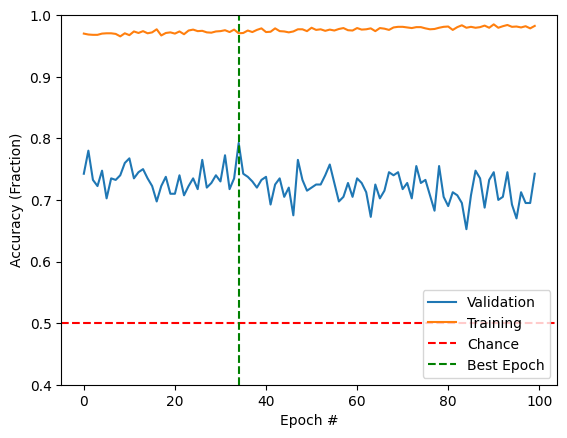

In [ ]:
plot_acc(cnn_history)

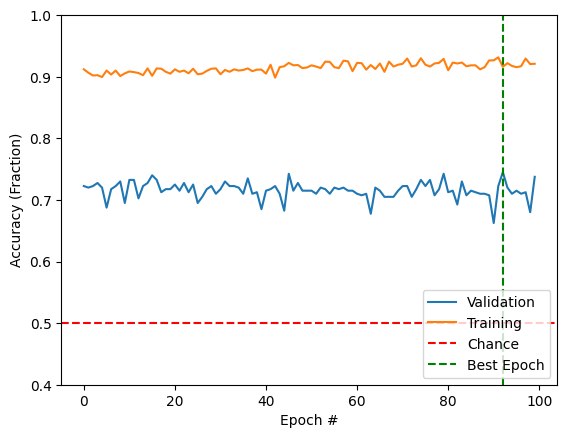

In [ ]:
plot_acc(dense_history)

In [ ]:
transfer = TransferClassifier(name = 'VGG19')
tranfer_history = transfer.fit(train_data, train_labels, epochs = 7, validation_data = (test_data, test_labels), shuffle = True, callbacks = [monitor])
### END CODE

Epoch 1/7
63/63 [==============================] - 7s 71ms/step - loss: 0.6394 - accuracy: 0.6450 - val_loss: 0.5178 - val_accuracy: 0.7725
Epoch 2/7
63/63 [==============================] - 4s 66ms/step - loss: 0.3992 - accuracy: 0.8370 - val_loss: 0.7880 - val_accuracy: 0.6600
Epoch 3/7
63/63 [==============================] - 4s 65ms/step - loss: 0.2946 - accuracy: 0.8845 - val_loss: 0.5095 - val_accuracy: 0.8125
Epoch 4/7
63/63 [==============================] - 4s 66ms/step - loss: 0.2186 - accuracy: 0.9190 - val_loss: 0.7417 - val_accuracy: 0.7675
Epoch 5/7
63/63 [==============================] - 4s 66ms/step - loss: 0.1727 - accuracy: 0.9345 - val_loss: 1.0123 - val_accuracy: 0.7175
Epoch 6/7
63/63 [==============================] - 4s 66ms/step - loss: 0.1868 - accuracy: 0.9375 - val_loss: 0.4361 - val_accuracy: 0.8575
Epoch 7/7
63/63 [==============================] - 4s 66ms/step - loss: 0.1641 - accuracy: 0.9485 - val_loss: 0.5514 - val_accuracy: 0.8325


In [ ]:
score = transfer.evaluate(test_data, test_labels)

13/13 [==============================] - 0s 23ms/step - loss: 0.5514 - accuracy: 0.8325


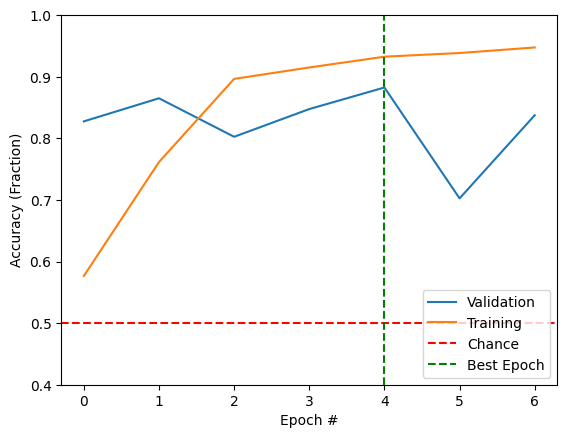

In [ ]:
plot_acc(tranfer_history)

In [ ]:
best_model = transfer

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
predictions = (best_model.predict(test_data) > 0.5).astype("int32")
print(accuracy_score(predictions, test_labels))

13/13 [==============================] - 0s 22ms/step
0.81


In [ ]:
confusion = confusion_matrix(test_labels, predictions)
print(confusion)

[[127  73]
 [  3 197]]


In [ ]:
tp  = confusion[1][1]
tn  = confusion[0][0]
fp = confusion[0][1]
fn = confusion[1][0]

print('True positive: %d'%tp)
print('True negative: %d'%tn)
print('False positive: %d'%fp)
print('False negative: %d'%fn)

True positive: 197
True negative: 127
False positive: 73
False negative: 3


In [ ]:
# grab our plotting package
import seaborn as sns
import matplotlib.pyplot as plt

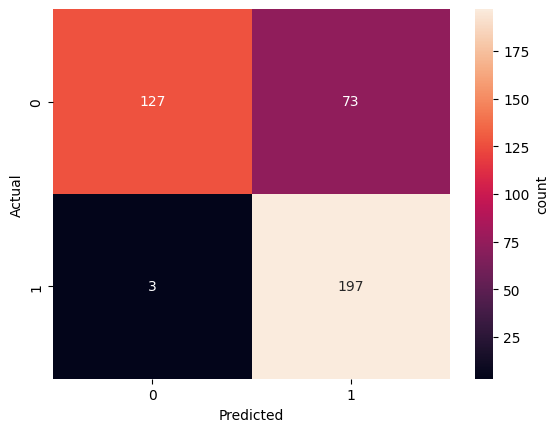

In [ ]:
sns.heatmap(confusion, annot = True, fmt = 'd', cbar_kws={'label':'count'});
plt.ylabel('Actual');
plt.xlabel('Predicted');